#### Import libraries

In [1]:
import pandas as pd  
import torch  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import joblib
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

#### Step 1: Preprocess the Data

In [33]:
# Load data
df = pd.read_csv('data.csv')
print(df.head(4))
# Separate features and target
X = df[["VC", "VB", "IB"]].values
y = df["IC"].values.reshape(-1, 1)

# Create train/validation/test splits (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=1234)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234)

# Save X_test and y_test to a file for later use
test_data = pd.DataFrame(X_test, columns=["VC", "VB", "IB"])
test_data["IC"] = y_test  # Add the target column
test_data.to_csv("test_data_.csv", index=False)

# Scale the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit on training data, transform all sets
X_train = scaler_X.fit_transform(X_train)
y_train = scaler_y.fit_transform(y_train)
X_val = scaler_X.transform(X_val)
y_val = scaler_y.transform(y_val)
X_test = scaler_X.transform(X_test)
y_test = scaler_y.transform(y_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Save scalers for later inference
joblib.dump(scaler_X, 'scaler_X_.pkl')
joblib.dump(scaler_y, 'scaler_y_.pkl')

      VC       VB        IB            IC
0  0.000  0.49800  0.000001 -9.530000e-07
1  0.001  0.49998  0.000001 -8.020000e-07
2  0.002  0.50101  0.000001 -6.190000e-07
3  0.003  0.50198  0.000001 -4.450000e-07


['scaler_y_.pkl']

#### CREATE MODEL, TRAIN AND SAVE THE TRAINED MODEL

In [3]:
# Define the Neural Network Architecture
class BJTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 256),  # Input: 3 features (VC, VB, IB)
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)     # Output: Predicted IC
        )
    def forward(self, x):
        return self.layers(x)

# Create model instance
model = BJTModel()

# Prepare data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')
epochs_no_improve = 0
EPOCHS = 100
# Training loop
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    #print(f"Epoch {epoch+1}: Validation Loss = {val_loss:.6f}")
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}")
    
    # Uncomment below to activate early stopping
        # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model_test_.pth')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

# Save the trained model
torch.save(model.state_dict(), "bjt_model_.pth")

Epoch 1/100, Loss: 0.000244, Val Loss: 0.000268
Epoch 2/100, Loss: 0.000572, Val Loss: 0.000261
Epoch 3/100, Loss: 0.000031, Val Loss: 0.000238
Epoch 4/100, Loss: 0.000890, Val Loss: 0.000240
Epoch 5/100, Loss: 0.000488, Val Loss: 0.000331
Epoch 6/100, Loss: 0.000463, Val Loss: 0.000071
Epoch 7/100, Loss: 0.000083, Val Loss: 0.000077
Epoch 8/100, Loss: 0.000070, Val Loss: 0.000197
Epoch 9/100, Loss: 0.000108, Val Loss: 0.000091
Epoch 10/100, Loss: 0.000492, Val Loss: 0.000157
Epoch 11/100, Loss: 0.000011, Val Loss: 0.000072
Epoch 12/100, Loss: 0.000042, Val Loss: 0.000082
Epoch 13/100, Loss: 0.000005, Val Loss: 0.000065
Epoch 14/100, Loss: 0.000260, Val Loss: 0.000068
Epoch 15/100, Loss: 0.000057, Val Loss: 0.000085
Epoch 16/100, Loss: 0.000045, Val Loss: 0.000097
Epoch 17/100, Loss: 0.000049, Val Loss: 0.000079
Epoch 18/100, Loss: 0.000078, Val Loss: 0.000072
Epoch 19/100, Loss: 0.000019, Val Loss: 0.000048
Epoch 20/100, Loss: 0.000028, Val Loss: 0.000081
Epoch 21/100, Loss: 0.000013,

#### Load model, load scaler and test it. 

In [4]:

import torch
import pandas as pd
import numpy as np
import joblib
from torch.utils.data import DataLoader, TensorDataset

# # Define your model class and load its instance if not already done so
# class BJTModel(torch.nn.Module):
#     def __init__(self):
#         super(BJTModel, self).__init__()
#         self.layers = torch.nn.Sequential(
#             torch.nn.Linear(3, 256),
#             torch.nn.ReLU(),
#             torch.nn.Linear(256, 128),
#             torch.nn.ReLU(),
#             torch.nn.Linear(128, 64),
#             torch.nn.ReLU(),
#             torch.nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         return self.layers(x)

# # Initialize the model
# model = BJTModel()

# 1. Load the trained model
model.load_state_dict(torch.load('bjt_model_.pth'))
model.eval()  # Set to evaluation mode

# 2. Load test data and scalers
test_df = pd.read_csv('test_data_.csv')
scaler_X = joblib.load('scaler_X_.pkl')
scaler_y = joblib.load('scaler_y_.pkl')

# 3. Prepare test data
X_test = test_df[["VC", "VB", "IB"]].values
y_test = test_df["IC"].values.reshape(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 4. Define inference function
def predict_ic(vc, vb, ib):
    """Predict collector current (IC) given VC, VB, and IB values"""
    # Prepare input data
    input_data = np.array([[vc, vb, ib]], dtype=np.float32)
    input_scaled = scaler_X.transform(input_data)
    input_tensor = torch.tensor(input_scaled, dtype=torch.float32)
    
    # Make prediction
    with torch.no_grad():
        pred_scaled = model(input_tensor)
    
    # Convert back to original scale
    return scaler_y.inverse_transform(pred_scaled.numpy())[0][0]

# 5. Evaluate model on test data
VC_list, VB_list, IB_list = [], [], []
IC_actual, IC_predicted = [], []

with torch.no_grad():
    for x, y in test_loader:
        # Extract values from current batch
        VC_batch = x[:, 0].numpy()
        VB_batch = x[:, 1].numpy()
        IB_batch = x[:, 2].numpy()
        IC_batch = y.numpy().flatten()
        
        # Make predictions for each data point
        for VC, VB, IB in zip(VC_batch, VB_batch, IB_batch):
            predicted = predict_ic(VC, VB, IB)
            
            # Store values
            VC_list.append(VC)
            VB_list.append(VB)
            IB_list.append(IB)
            IC_predicted.append(predicted)
        
        IC_actual.extend(IC_batch)

# 6. Create results dataframe
results_df = pd.DataFrame({
    'VC': VC_list,
    'VB': VB_list,
    'IB': IB_list,
    'IC_Actual': IC_actual,
    'IC_Predicted': IC_predicted
})

#### Plots with enhance styling and background.

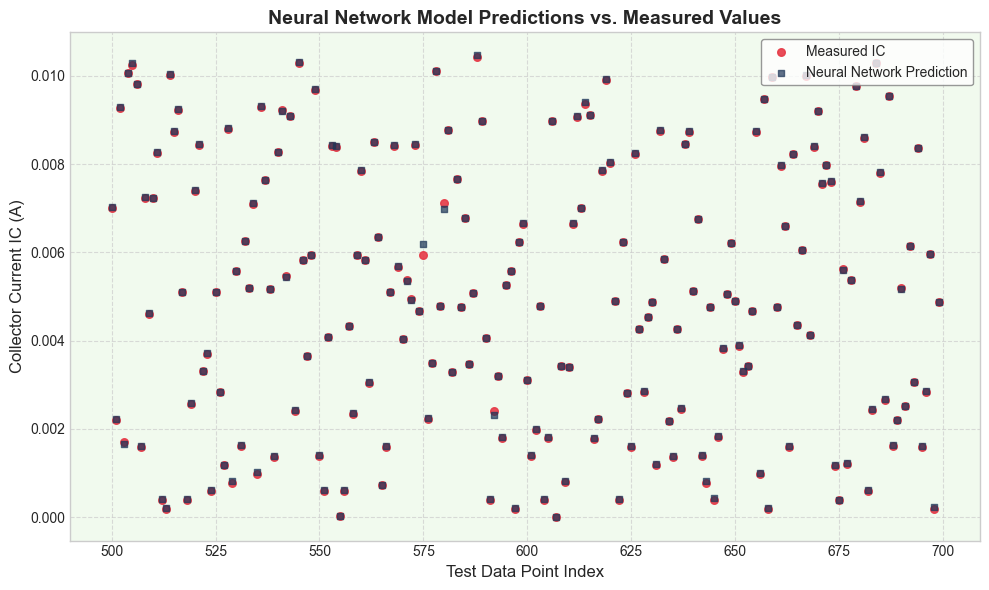

In [58]:
# 7. Visualize results with enhanced styling
plt.style.use('seaborn-v0_8-whitegrid')  # Use seaborn style for a clean look

# Set consistent color palette
COLORS = {'measured': '#E63946', 'predicted': '#1D3557', 'background': '#F1FAEE'}

# Plot 1: Comparison of actual vs predicted for a subset of data points
plt.figure(figsize=(10, 6))
sample_range = slice(500, 700)  # Visualize a subset of points
x_indices = range(len(results_df))[sample_range]

# Add light background
ax = plt.gca()
ax.set_facecolor(COLORS['background'])
plt.grid(True, linestyle='--', alpha=0.7)

# Plot data points
plt.scatter(x_indices, results_df['IC_Actual'][sample_range], 
            color=COLORS['measured'], s=30, label='Measured IC', alpha=0.9)
plt.scatter(x_indices, results_df['IC_Predicted'][sample_range], 
            color=COLORS['predicted'], marker='s', s=25, alpha=0.7, label='Neural Network Prediction')

# Improve styling
plt.title('Neural Network Model Predictions vs. Measured Values', fontsize=14, fontweight='bold')
plt.xlabel('Test Data Point Index', fontsize=12)
plt.ylabel('Collector Current IC (A)', fontsize=12)
plt.legend(frameon=True, facecolor='white', edgecolor='gray')
plt.tight_layout()
plt.savefig('bjt_predictions_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



#### PLOT IV CURVE

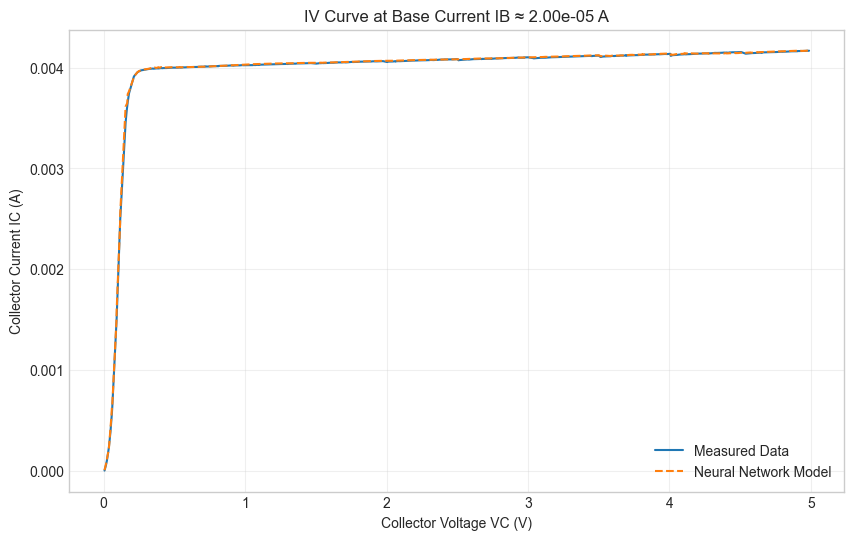

In [34]:
# Plot 2: IV curve for a specific base current
target_ib = 2.0e-05  # Target base current (20 µA)
tolerance = 0.5e-6  # Tolerance for selecting points

# Filter data points with the specified base current
selected_data = results_df[(results_df['IB'] >= target_ib - tolerance) &
                          (results_df['IB'] <= target_ib + tolerance)]
selected_data_sorted = selected_data.sort_values(by='VC')

# Plot IV curve
plt.figure(figsize=(10, 6))
plt.plot(selected_data_sorted['VC'], selected_data_sorted['IC_Actual'],
         label='Measured Data')
plt.plot(selected_data_sorted['VC'], selected_data_sorted['IC_Predicted'],
         label='Neural Network Model', linestyle='--')

plt.xlabel('Collector Voltage VC (V)')
plt.ylabel('Collector Current IC (A)')
plt.title(f'IV Curve at Base Current IB ≈ {target_ib:.2e} A')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

##### PLOT IV CURVES (MULTIPLE)

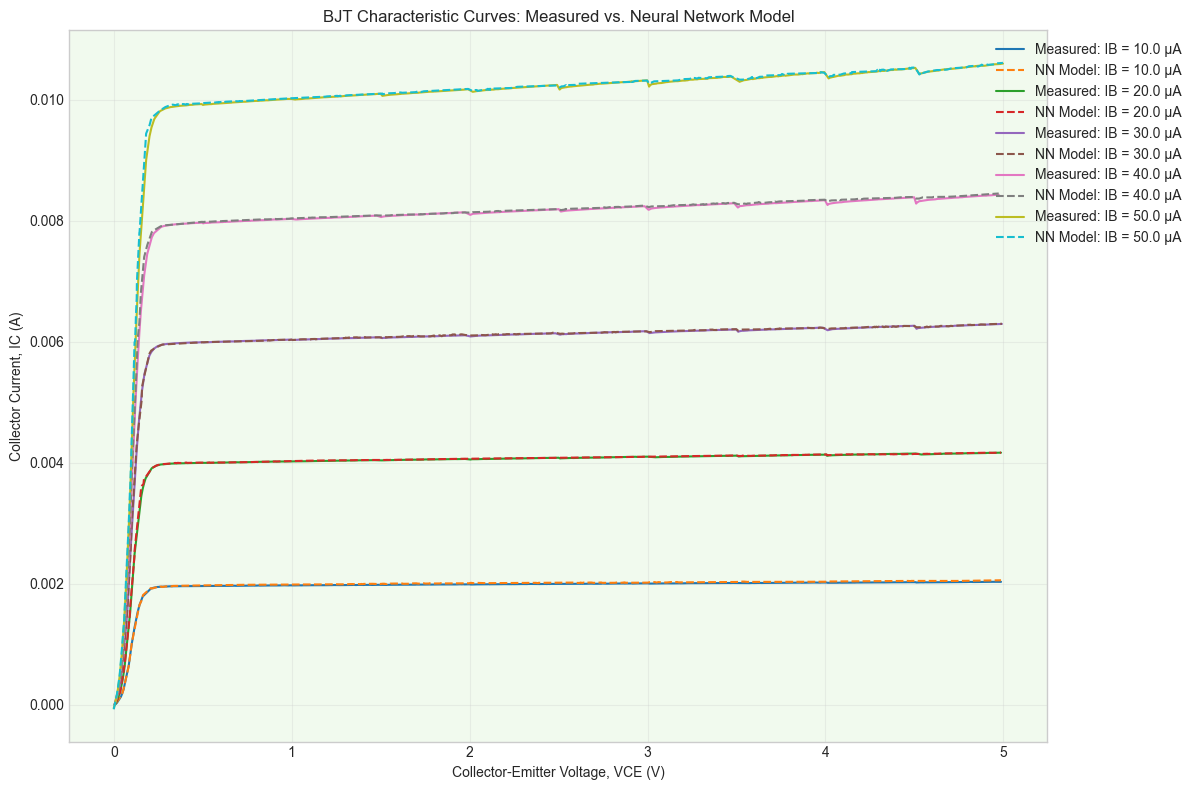

In [62]:
# Define range of base currents to plot
base_currents = np.array([10, 20, 30, 40, 50]) * 1e-6  # in amperes
tolerance = 0.5e-6  # Tolerance for filtering data points

# Create figure
plt.figure(figsize=(12, 8))

# Generate IV curves for each base current
for ib in base_currents:
    # Filter data points with the specified base current
    selected_data = results_df[(results_df['IB'] >= ib - tolerance) & 
                              (results_df['IB'] <= ib + tolerance)]
    
    if len(selected_data) > 0:
        # Sort by collector voltage for proper curve plotting
        selected_data_sorted = selected_data.sort_values(by='VC')
        
        # Plot measured data
        plt.plot(selected_data_sorted['VC'], selected_data_sorted['IC_Actual'],
                 label=f'Measured: IB = {ib*1e6:.1f} µA')
        
        # Plot neural network predictions (dashed lines)
        plt.plot(selected_data_sorted['VC'], selected_data_sorted['IC_Predicted'],
                 linestyle='--', label=f'NN Model: IB = {ib*1e6:.1f} µA')

plt.xlabel('Collector-Emitter Voltage, VCE (V)')
plt.ylabel('Collector Current, IC (A)')
plt.title('BJT Characteristic Curves: Measured vs. Neural Network Model')
ax = plt.gca()
ax.set_facecolor('#F1FAEE')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()

In [ ]:
print("Part 1 END")

#### COMPARE WITH PYSPICE SIMULATION


#### STEP 1. Create the Transistor Circuit

In [36]:
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import u_uA, u_uV, u_V

def create_transistor_circuit(base_current=10):
    circuit = Circuit('Transistor')
    Ibase = circuit.I('base', circuit.gnd, 'base', base_current@u_uA)
    Vcollector = circuit.V('collector', 'collector', circuit.gnd, 5@u_V)
    circuit.BJT(1, 'collector', 'base', circuit.gnd, model='2n2222')
    # Define the model parameters
    circuit.model('2n2222', 'npn', IS=1.32E-14, VAF=102, BF=201, IKF=0.64, XTB=1.5, BR=3, CJC=8E-12, 
                  CJE=25E-12, TR=100E-9, TF=400E-12, ITF=1, VTF=2, XTF=3, RB=10, RC=0.3, RE=0.2)
    return circuit

circuit = create_transistor_circuit(base_current=10)
print(circuit)

.title Transistor
Ibase 0 base 10uA
Vcollector collector 0 5V
Q1 collector base 0 2n2222
.model 2n2222 npn (BF=201 BR=3 CJC=8e-12 CJE=2.5e-11 IKF=0.64 IS=1.32e-14 ITF=1 RB=10 RC=0.3 RE=0.2 TF=4e-10 TR=1e-07 VAF=102 VTF=2 XTB=1.5 XTF=3)



#### Step 2. Run the VC Vs IC Simulation

In [41]:
#Run simulations with vectorized approach
VC, VB, IB, IC, IC_NN = [], [], [], [], []
circuit = create_transistor_circuit()

for base_current in np.arange(10, 60, 10):
    # Update base current
    ib_value = base_current * 1e-6
    circuit.Ibase.dc_value = base_current@u_uA
    
    # Run DC sweep
    simulator = circuit.simulator(temperature=27, nominal_temperature=27)
    analysis = simulator.dc(Vcollector=slice(0, 5.00, 0.01))
    
    # Store base current for all points in this sweep
    collector_values = [float(v) for v in analysis.collector]
    base_values = [float(v) for v in analysis.base]
    
    # Extend results lists
    VC.extend(collector_values)
    VB.extend(base_values)
    IB.extend([ib_value] * len(analysis.Vcollector))
    IC.extend([-float(v) for v in analysis.Vcollector])
    IC_NN.extend([predict_ic(c, b, ib_value) for c, b in zip(collector_values, base_values)])

# Create DataFrames directly from the complete lists
df_sim = pd.DataFrame({'VC': VC, 'VB': VB, 'IB': IB, 'IC': IC})
df_nn = pd.DataFrame({'VC': VC, 'VB': VB, 'IB': IB, 'IC_NN': IC_NN})

# print(df_sim.head(4))
# print(df_nn.head(4))

#### Step 3. Filter the data

In [42]:
def filter_results(df, selected_ib_values, tolerance=0.5e-6, max_vc=5):
    # Filter for selected IB values
    filtered_df = pd.DataFrame()
    for target_ib in selected_ib_values:
        selected_group = df[(df['IB'] >= target_ib - tolerance) & 
                            (df['IB'] <= target_ib + tolerance)]
        filtered_df = pd.concat([filtered_df, selected_group])
    
    # Remove rows with VC values greater than max_vc
    filtered_df = filtered_df[filtered_df['VC'] <= max_vc]
    
    # Sort by VC
    return filtered_df.sort_values(by='VC')

#### Step 4.Create Plot Function

In [56]:
import matplotlib.pyplot as plt

def plot_comparison(sim_df, nn_df, selected_ib_values, tolerance=0.5e-6):
    #plt.style.use('seaborn-v0_8-whitegrid')  # Use seaborn style for a clean look
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_title('Collector Current vs Collector-Emitter Voltage for Different Base Currents')
    ax.set_xlabel('Collector-Emitter Voltage, VCE [V]')
    ax.set_ylabel('Collector Current, IC [A]')
    # Add light background
    ax = plt.gca()
    ax.set_facecolor('#F1FAEE')
    
    # Plot PySpice results (solid lines)
    for target_ib in selected_ib_values:
        selected_group = sim_df[(sim_df['IB'] >= target_ib - tolerance) & 
                               (sim_df['IB'] <= target_ib + tolerance)]
        ax.plot(selected_group['VC'], selected_group['IC'],
                label=f'PySpice: IB = {(target_ib*1e6):.1f} μA')
    
    # Plot Neural Network predictions (dashed lines)
    for target_ib in selected_ib_values:
        selected_group = nn_df[(nn_df['IB'] >= target_ib - tolerance) & 
                              (nn_df['IB'] <= target_ib + tolerance)]
        ax.plot(selected_group['VC'], selected_group['IC_Predicted'],
                linestyle='--', label=f'NN Model: IB = {(target_ib*1e6):.1f} μA')
    
    ax.grid(True, alpha=0.3)
    ax.legend(loc='right')
    plt.tight_layout()
    #return fig

#### Visualize PySpice and Neural Network Results

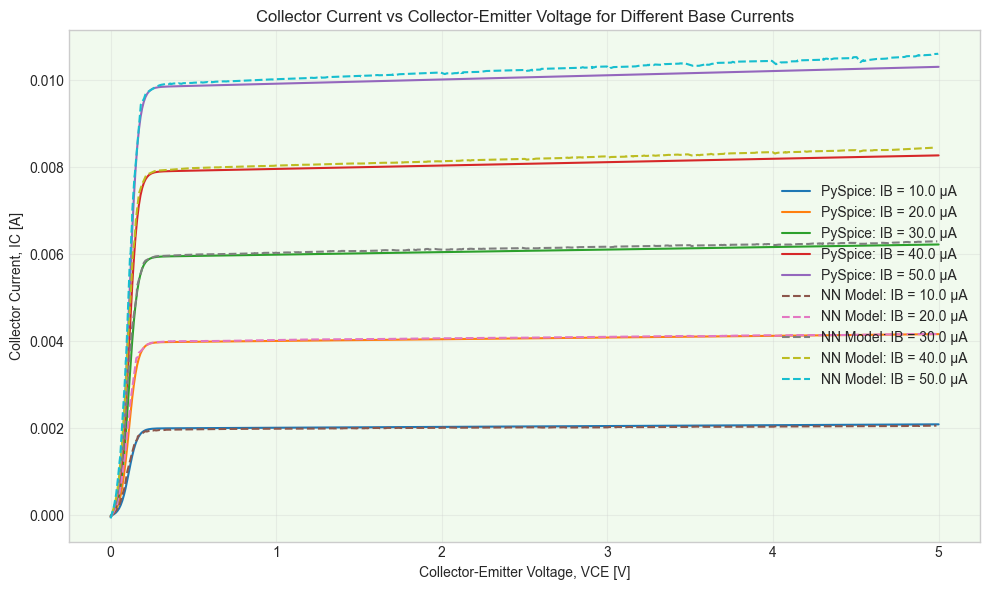

In [57]:
#selected_ib_values = np.array([60e-6, 80e-6])  # 60μA and 80μA
selected_ib_values = np.arange(10e-6, 60e-6, 10e-6)
    
# 3. Filter simulation results
filtered_sim_df = filter_results(df_sim, selected_ib_values)

# 4. Filter Neural Network results
filtered_nn_df = filter_results(results_df, selected_ib_values)

plot_comparison(filtered_sim_df, filtered_nn_df, selected_ib_values, tolerance=0.5e-6)